# CICERO SCM Thermal Model Comparison - Two-Layer Ocean vs Upwelling Diffusion

This notebook compares the outputs of the Two-Layer Ocean Model with the Upwelling Diffusion Model using the same scenario inputs.

Import some stuff

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

Import the model

In [2]:
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [3]:
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Define a function to convert model output to a dataframe

In [4]:
def to_df(cscm):
    out=pd.concat([pd.DataFrame(v) for k, v in cscm.results.items()], axis = 1, keys = list(cscm.results.keys()))
    return out

set up input directories

In [5]:
test_data_dir = os.path.join(os.getcwd(), '../', 'tests', 'test-data')

# Read in datafiles into dataframes

In [6]:
# NBVAL_IGNORE_OUTPUT
#Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_SO2,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [7]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')
df_nat_ch4.head()


,CH4
year,
1750,269.4273
1751,270.9068
1752,273.0183
1753,272.0470
1754,271.1915


Read forcing

In [8]:
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_ssp2_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
Component,,,,,,,,,,,,,,,,,,,,,
1700,276.746000,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.749995,706.247004,272.243047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.757998,706.375031,272.266047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.757001,706.491002,272.298047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.755000,706.602046,272.331052,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [9]:
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input.head()

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1750,0.002592,0.081127,19.019783,0.054710,2.440048,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.927690,1.353250,12.520269,0.744520,2.927399
1751,0.002593,0.082619,18.915109,0.055744,2.408379,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828060,343.926367,59.088126,6.860142,1.335274,12.279280,0.737652,2.909437
1752,0.002594,0.084139,18.889712,0.056797,2.397116,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828658,341.809034,58.631997,6.819482,1.326617,12.121816,0.737695,2.912659
1753,0.002594,0.085687,19.121377,0.057870,2.410693,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.812105,343.675456,59.026349,6.881439,1.328560,12.249330,0.743391,2.933215
1754,0.002595,0.087263,19.509061,0.058963,2.462065,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.841598,349.815625,60.269945,7.015189,1.346553,12.593635,0.752796,2.965138


# Set up model run with defined input variables

In [10]:
# NBVAL_IGNORE_OUTPUT
scen = 'test'
cscm_dir=CICEROSCM({
            "gaspam_data": gaspam,
            "emstart": 1751,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
        })

Carbon Model=default


# Run Upwelling Diffusion Model (UDM)

First, let's run the scenario with the upwelling diffusion model:

## Parameter Organization

The model parameters are organized into different categories:

- **pamset_udm**: Physical oceanographic parameters (upwelling-diffusion model)
- **pamset_emiconc**: Emissions and concentrations parameters, including forcing coefficients
- **pamset_carbon**: Carbon cycle specific parameters

### Carbon Cycle Parameters

Carbon cycle parameters should be passed in `pamset_carbon`. This includes:

- Physical parameters: `beta_f`, `mixed_carbon`, `npp0`, `ml_w_sigmoid`, `ml_fracmax`, `ml_t_half`, etc.
- Function parameters: Can use either dictionary or flat format

### Using Flat Carbon Cycle Parameters

The carbon cycle function parameters can now be specified using "flat" parameter names instead of requiring dictionary structures. For example, instead of:

```python
rb_function = {"coeffs": [0.5, 0.25, 0.25], "timescales": [2.5, 10.0, 60.0]}
```

You can now use:

```python
'rb_coef0': 0.5, 'rb_coef1': 0.25, 'rb_coef2': 0.25,
'rb_tim0': 2.5, 'rb_tim1': 10.0, 'rb_tim2': 60.0
```

In [11]:
# NBVAL_IGNORE_OUTPUT
# Run with Upwelling Diffusion Model (UDM)
cscm_udm_results = cscm_dir._run({
            "results_as_dict":True,
            "carbon_cycle_outputs":True
        },
    pamset_udm={"threstemp": 7.0, #scales vertical velocity as a function of mixed layer temperature
                    "rlamdo":16.0,#air-sea heat exchange coefficient (wm^-2K^-1)
                    "akapa":0.634, #vertical heat diffusivity
                    "cpi":0.4, #temperature change ratio: polar to nonpolar region
                    "W":4, #vertical velocity (m/yr)
                    "beto":3.5, #ocean interhemispheric heat exchange coeff (Wm^-2K^-1)
                    "lambda":0.54,
                    "mixed":60.0,  #mixed layer depth
                    "foan":0.61, #fraction of northern hemisphere covered by ocean
                    "foas":0.81, #fraction of northern hemisphere covered by ocean
                    "ebbeta":0.0,#atmospheric interhemispheric heat exchange 
                    "fnso":0.7531, #ocean area ratio, northern to southern hemisphere
                    "lm":40, #number of vertical layers
                    "ldtime":12,
                   },
    pamset_emiconc={"qbmb": 0.0,
                    "qo3": 0.5,
                    "qdirso2": -0.00308,
                    "qindso2": -0.97 / 57.052577209999995,
                    "qbc": 0.0279,
                    "qoc": -0.00433,
                    "qh2o_ch4": 0.091915,
                    "ref_yr": 2010
                    },
    pamset_carbon={
                    "beta_f": 0.,
                    "mixed_carbon": 75.0,
                    "qnmvoc": 0.0,
                    "qnh3": 0.0,
                    "qnox": 0.0,
                    "npp0": 60.0,
                    "npp_t_half": 0.5,
                    "npp_w_sigmoid": 4,
                    "npp_t_threshold": 6,
                    "npp_w_threshold": 4,
                    "ml_w_sigmoid": 3.0,
                    "ml_fracmax": 0.5,
                    "ml_t_half": 0.5,
                    'rb_coef0': 0.5,
                    'rb_coef1': 0.25,
                    'rb_coef2': 0.25,
                    'rb_tim0': 2.5,
                    'rb_tim1': 10.0,
                    'rb_tim2': 60.0,
                    'rs_coef0': 0.1,
                    'rs_coef1': 0.6,
                    'rs_coef2': 0.15,
                    'rs_coef3': 0.15,
                    'rs_tim0': .8,
                    'rs_tim1': 7,
                    'rs_tim2': 80,
                    'beta_f': 1.0
                }
            )   

# Store UDM results
results_udm = cscm_dir.results.copy()

# Run Two-Layer Ocean Model

Now let's run the same scenario with the two-layer ocean model using equivalent parameters:

In [12]:
# NBVAL_IGNORE_OUTPUT
# Run with Two-Layer Ocean Model
cscm_twolayer_results = cscm_dir._run({
            "results_as_dict":True,
            "carbon_cycle_outputs":True,
            "thermal_model": "two_layer_ocean"  # Switch to two-layer model
        },
    pamset_udm={
                    "lambda": 0.54,        # Climate feedback parameter (equivalent to lambda from UDM)
                    "mixed": 60.0,         # Mixed layer depth (equivalent to mixed from UDM)
                    "deep": 1000.0,        # Deep layer depth 
                    "k": 0.8,              # Coupling coefficient between layers
                    "efficacy": 1.0,       # Efficacy of deep ocean heat uptake
                    "foan": 0.61,          # NH ocean fraction (same as UDM)
                    "foas": 0.81           # SH ocean fraction (same as UDM)
                   },
    pamset_emiconc={"qbmb": 0.0,
                    "qo3": 0.5,
                    "qdirso2": -0.00308,
                    "qindso2": -0.97 / 57.052577209999995,
                    "qbc": 0.0279,
                    "qoc": -0.00433,
                    "qh2o_ch4": 0.091915,
                    "ref_yr": 2010
                    },
    pamset_carbon={
                    "beta_f": 0.,
                    "mixed_carbon": 75.0,
                    "qnmvoc": 0.0,
                    "qnh3": 0.0,
                    "qnox": 0.0,
                    "npp0": 60.0,
                    "npp_t_half": 0.5,
                    "npp_w_sigmoid": 4,
                    "npp_t_threshold": 6,
                    "npp_w_threshold": 4,
                    "ml_w_sigmoid": 3.0,
                    "ml_fracmax": 0.5,
                    "ml_t_half": 0.5,
                    'rb_coef0': 0.5,
                    'rb_coef1': 0.25,
                    'rb_coef2': 0.25,
                    'rb_tim0': 2.5,
                    'rb_tim1': 10.0,
                    'rb_tim2': 60.0,
                    'rs_coef0': 0.1,
                    'rs_coef1': 0.6,
                    'rs_coef2': 0.15,
                    'rs_coef3': 0.15,
                    'rs_tim0': .8,
                    'rs_tim1': 7,
                    'rs_tim2': 80,
                    'beta_f': 1.0
                }
            )

# Store Two-Layer results
results_twolayer = cscm_dir.results.copy()

# Compare Results

Now let's compare the results from both thermal models:

Available columns:
  ('dT_glob', 0)
  ('dT_NH', 0)
  ('dT_SH', 0)
  ('dT_glob_air', 0)
  ('dT_NH_air', 0)
  ('dT_SH_air', 0)
  ('dT_glob_sea', 0)
  ('dT_NH_sea', 0)
  ('dT_SHsea', 0)


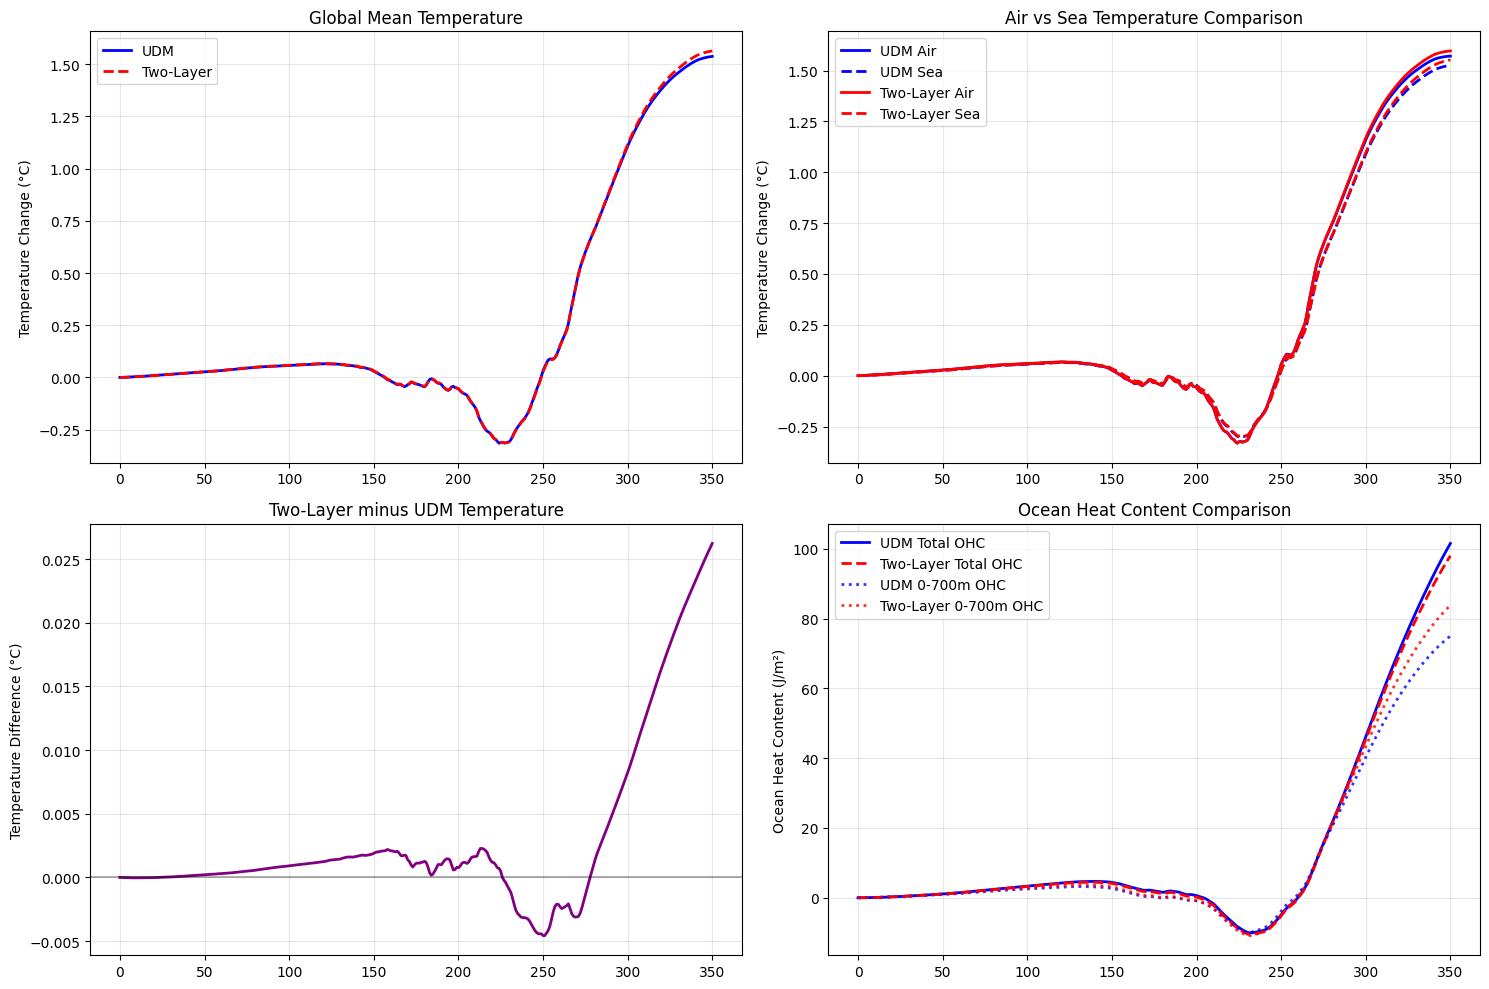

In [21]:
# First, let's check the actual column names
print("Available columns:")
for col in df_udm.columns:
    if 'dT' in str(col) or 'TEMP' in str(col):
        print(f"  {col}")

# Compare global mean temperatures
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Get years for plotting
years = df_udm.index

# Global temperature comparison - using the correct column name
temp_col_udm = ('dT_glob', 0)  # Based on the output, this should be the main temperature
temp_col_twolayer = ('dT_glob', 0)

axes[0,0].plot(years, df_udm[temp_col_udm], 'b-', label='UDM', linewidth=2)
axes[0,0].plot(years, df_twolayer[temp_col_twolayer], 'r--', label='Two-Layer', linewidth=2)
axes[0,0].set_ylabel('Temperature Change (°C)')
axes[0,0].set_title('Global Mean Temperature')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Air vs Sea temperature comparison 
air_col = ('dT_glob_air', 0)
sea_col = ('dT_glob_sea', 0)

if air_col in df_twolayer.columns and sea_col in df_twolayer.columns:
    # Plot both UDM and Two-Layer air/sea temperatures
    axes[0,1].plot(years, df_udm[air_col], 'b-', label='UDM Air', linewidth=2)
    axes[0,1].plot(years, df_udm[sea_col], 'b--', label='UDM Sea', linewidth=2)
    axes[0,1].plot(years, df_twolayer[air_col], 'r-', label='Two-Layer Air', linewidth=2)
    axes[0,1].plot(years, df_twolayer[sea_col], 'r--', label='Two-Layer Sea', linewidth=2)
    axes[0,1].set_ylabel('Temperature Change (°C)')
    axes[0,1].set_title('Air vs Sea Temperature Comparison')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
else:
    # Fallback if air/sea temps not available
    axes[0,1].plot(years, df_udm[temp_col_udm], 'b-', label='UDM', linewidth=2)
    axes[0,1].plot(years, df_twolayer[temp_col_twolayer], 'r--', label='Two-Layer', linewidth=2)
    axes[0,1].set_ylabel('Temperature Change (°C)')
    axes[0,1].set_title('Global Temperature (Detail)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

# Temperature difference
temp_diff = df_twolayer[temp_col_twolayer] - df_udm[temp_col_udm]
axes[1,0].plot(years, temp_diff, 'purple', linewidth=2)
axes[1,0].set_ylabel('Temperature Difference (°C)')
axes[1,0].set_title('Two-Layer minus UDM Temperature')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Ocean heat content comparison
ohc_total_col = ('OHCTOT', 0)
ohc_700_col = ('OHC700', 0)

if ohc_total_col in df_twolayer.columns:
    # Plot total OHC comparison
    axes[1,1].plot(years, df_udm[ohc_total_col], 'b-', label='UDM Total OHC', linewidth=2)
    axes[1,1].plot(years, df_twolayer[ohc_total_col], 'r--', label='Two-Layer Total OHC', linewidth=2)
    
    # Add 0-700m OHC comparison for both models
    if ohc_700_col in df_twolayer.columns and ohc_700_col in df_udm.columns:
        axes[1,1].plot(years, df_udm[ohc_700_col], 'b:', label='UDM 0-700m OHC', linewidth=2, alpha=0.8)
        axes[1,1].plot(years, df_twolayer[ohc_700_col], 'r:', label='Two-Layer 0-700m OHC', linewidth=2, alpha=0.8)
    
    axes[1,1].set_ylabel('Ocean Heat Content (J/m²)')
    axes[1,1].set_title('Ocean Heat Content Comparison')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
else:
    # Plot temperature comparison in later years
    axes[1,1].plot(years, df_udm[temp_col_udm], 'b-', label='UDM', linewidth=2)
    axes[1,1].plot(years, df_twolayer[temp_col_twolayer], 'r--', label='Two-Layer', linewidth=2)
    axes[1,1].set_ylabel('Temperature Change (°C)')
    axes[1,1].set_title('Temperature Comparison (2000-2100)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    # Zoom to later years
    axes[1,1].set_xlim(2000, 2100)

plt.tight_layout()
plt.show()

In [18]:
# Quantitative comparison at key time points
comparison_years = [2020, 2050, 2100]
temp_col = ('dT_glob', 0)  # Use the correct column name

print("Temperature Comparison at Key Years:")
print("="*50)
for year in comparison_years:
    if year in df_udm.index and year in df_twolayer.index:
        udm_temp = df_udm.loc[year, temp_col]
        twolayer_temp = df_twolayer.loc[year, temp_col]
        diff = twolayer_temp - udm_temp
        percent_diff = (diff / udm_temp) * 100 if udm_temp != 0 else 0
        
        print(f"\nYear {year}:")
        print(f"  UDM Temperature:      {udm_temp:.3f} °C")
        print(f"  Two-Layer Temperature: {twolayer_temp:.3f} °C")
        print(f"  Difference:           {diff:.3f} °C ({percent_diff:.1f}%)")

# Calculate correlation and RMSE
temp_udm = df_udm[temp_col]
temp_twolayer = df_twolayer[temp_col]

correlation = temp_udm.corr(temp_twolayer)
rmse = np.sqrt(((temp_twolayer - temp_udm) ** 2).mean())

print(f"\nOverall Statistics:")
print(f"  Correlation:          {correlation:.4f}")
print(f"  RMSE:                 {rmse:.4f} °C")
print(f"  Mean difference:      {(temp_twolayer - temp_udm).mean():.4f} °C")
print(f"  Max difference:       {(temp_twolayer - temp_udm).max():.4f} °C")
print(f"  Min difference:       {(temp_twolayer - temp_udm).min():.4f} °C")

Temperature Comparison at Key Years:

Year 2020:
  UDM Temperature:      nan °C
  Two-Layer Temperature: nan °C
  Difference:           nan °C (nan%)

Year 2050:
  UDM Temperature:      nan °C
  Two-Layer Temperature: nan °C
  Difference:           nan °C (nan%)

Year 2100:
  UDM Temperature:      nan °C
  Two-Layer Temperature: nan °C
  Difference:           nan °C (nan%)

Overall Statistics:
  Correlation:          1.0000
  RMSE:                 0.0074 °C
  Mean difference:      0.0030 °C
  Max difference:       0.0262 °C
  Min difference:       -0.0046 °C
